<a href="https://colab.research.google.com/github/txusser/Master_IA_Sanidad/blob/main/Modulo_2/2_3_4_Proyecto_Regresion_Lineal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este proyecto nuestro objetivo es construir un modelo de regresión lineal simple basado en sci-kit learn para predecir costes médicos a partir del conjunto de datos que puedes encontrar [en este enlace](https://www.kaggle.com/mirichoi0218/insurance))

El primer paso será subir a la máquina virtual de Google el archivo de datos

## Cargar librerías básicas y datos

In [15]:
# En primer lugar importamos las librerías de trabajo básicas en cualquier
# proyecto de aprendizaje automático
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rich.console import Console
console = Console()

# Y cargamos los datos contenidos en nuestro dataset (descargado y sub)
df = pd.read_csv("insurance.csv")
console.log(f"Cabecera del DataFrame: {df.head()}", style="bold yellow")

[16:02:18] Cabecera del DataFrame:    age     sex     bmi  children smoker       <ipython-input-15-54f681fcf565>:12
           region      charges                                                                                     
           0   19  female  27.900         0    yes  southwest  16884.92400                                         
           1   18    male  33.770         1     no  southeast   1725.55230                                         
           2   28    male  33.000         3     no  southeast   4449.46200                                         
           3   33    male  22.705         0     no  northwest  21984.47061                                         
           4   32    male  28.880         0     no  northwest   3866.85520                                         

## Exploración de datos
Como hemos visto en el Tema 2.3.3 uno de los primeros pasos que debemos realizar en todo proyecto de Aprendizaje Automático es la exploración descriptiva y visual de los datos de trabajo. Este proceso es esencial para comprender en profundidad la naturaleza de los datos con los que vamos a trabajar y establecer las bases sobre las cuales se construirán los modelos posteriores.


<ipython-input-13-a560966067b4>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.1, 0.1, 0.1, 1)). The keyword argument will take precedence.
  plt.plot(x, p, 'k', linewidth=2, color='red')


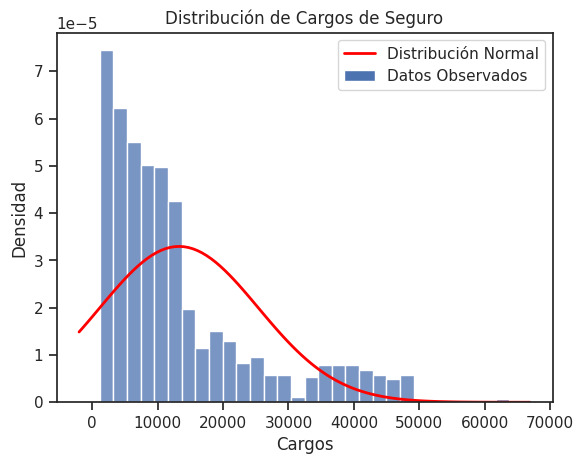

───────────────────────────────────────────── Estadísticas Relevantes ─────────────────────────────────────────────

Media de Cargos: 13270.42

Desviación Estándar de Cargos: 12105.48

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from rich.console import Console

console = Console()

# Observamos cómo se distribuye la variable objetivo "charges"
# que recoge los cargos realizados al seguro
sns.histplot(df['charges'], stat="density")
plt.title('Distribución de Cargos de Seguro')
plt.xlabel('Cargos')
plt.ylabel('Densidad')

# Ajustamos los datos a la distribución normal
mu, std = norm.fit(df['charges'])

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, 'k', linewidth=2, color='red')
plt.legend(['Distribución Normal', 'Datos Observados'])

# Mostrar el gráfico
plt.show()

# Imprimir estadísticas relevantes usando rich.Console
console.rule("Estadísticas Relevantes")
console.print(f"Media de Cargos: [bold]{mu:.2f}[/bold]")
console.print(f"Desviación Estándar de Cargos: [bold]{std:.2f}[/bold]")


El test de Shapiro-Wilk es una prueba estadística utilizada para evaluar si un conjunto de datos sigue una distribución normal. La distribución normal, también conocida como distribución gaussiana, es una distribución continua que es comúnmente encontrada en muchos fenómenos naturales y en estadísticas se considera como una base fundamental para muchos métodos y pruebas.

In [7]:
# Definamos una función para realizar un test de normalidad y verificar
# la gaussianidad (o no) de la distribución

from scipy.stats import norm, shapiro

def test_normality(data):
    stat, p_value = shapiro(data)
    console.rule("Test de Normalidad")
    console.print(f"Estadística de Test: [bold]{stat:.4f}[/bold]")
    console.print(f"P-valor: [bold]{p_value:.4f}[/bold]")

    if p_value > 0.05:
        console.print("Los datos siguen una distribución normal (p > 0.05).")
    else:
        console.print("Los datos no siguen una distribución normal (p <= 0.05).")
# Realizar el test de normalidad
test_normality(df['charges'])

─────────────────────────────────────────────── Test de Normalidad ────────────────────────────────────────────────

Estadística de Test: 0.8147

P-valor: 0.0000

Los datos no siguen una distribución normal (p <= 0.05).

De los anteriores resultados podemos concluir que la variable objetivo "charges" no sigue una distribución normal, sino más bien una distribución mixta, lo que podría ser un problema para obtener un rendimiento óptimo para nuestro modelo lineal

<ipython-input-9-c19b52797cb9>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr() # Usamos el método implementado por Pandas


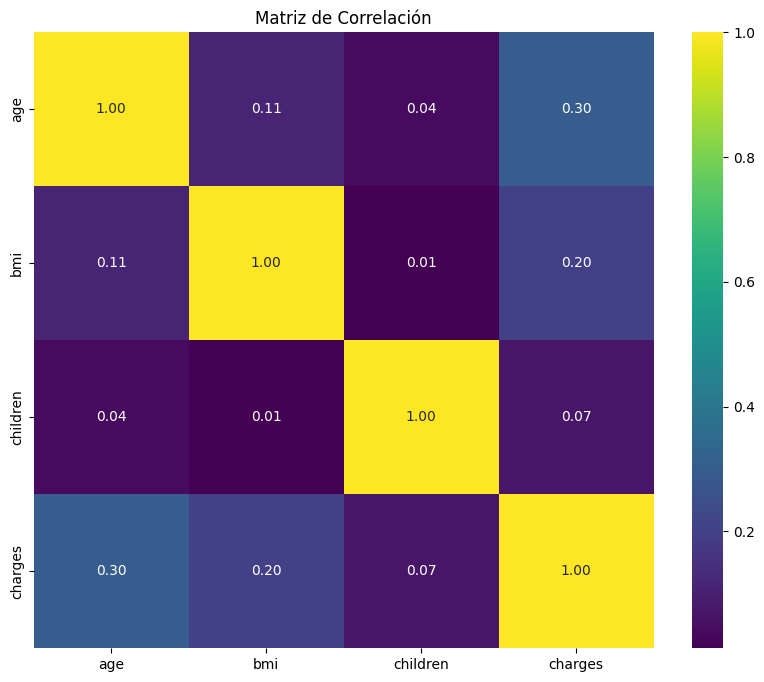

──────────────────────────────── Características Más Correlacionadas con 'charges' ────────────────────────────────

charges     1.000000
age         0.299008
bmi         0.198341
children    0.067998
Name: charges, dtype: float64

In [9]:
# Revisamos la matriz de correlación para ver posibles dependencias
correlation_matrix = df.corr() # Usamos el método implementado por Pandas

# Crear una figura y un eje para el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

# Imprimimos por pantalla la correlación entre características (y "charges") ordenando
# según mayor valor de correlación
console.rule("Características Más Correlacionadas con 'charges'")
charges_correlation = correlation_matrix['charges'].sort_values(ascending=False)
console.print(charges_correlation)

# Otra forma de obtener el mapa de calor empleando Seaborn:
# sns.heatmap(df.corr(),annot=True, cmap='viridis')

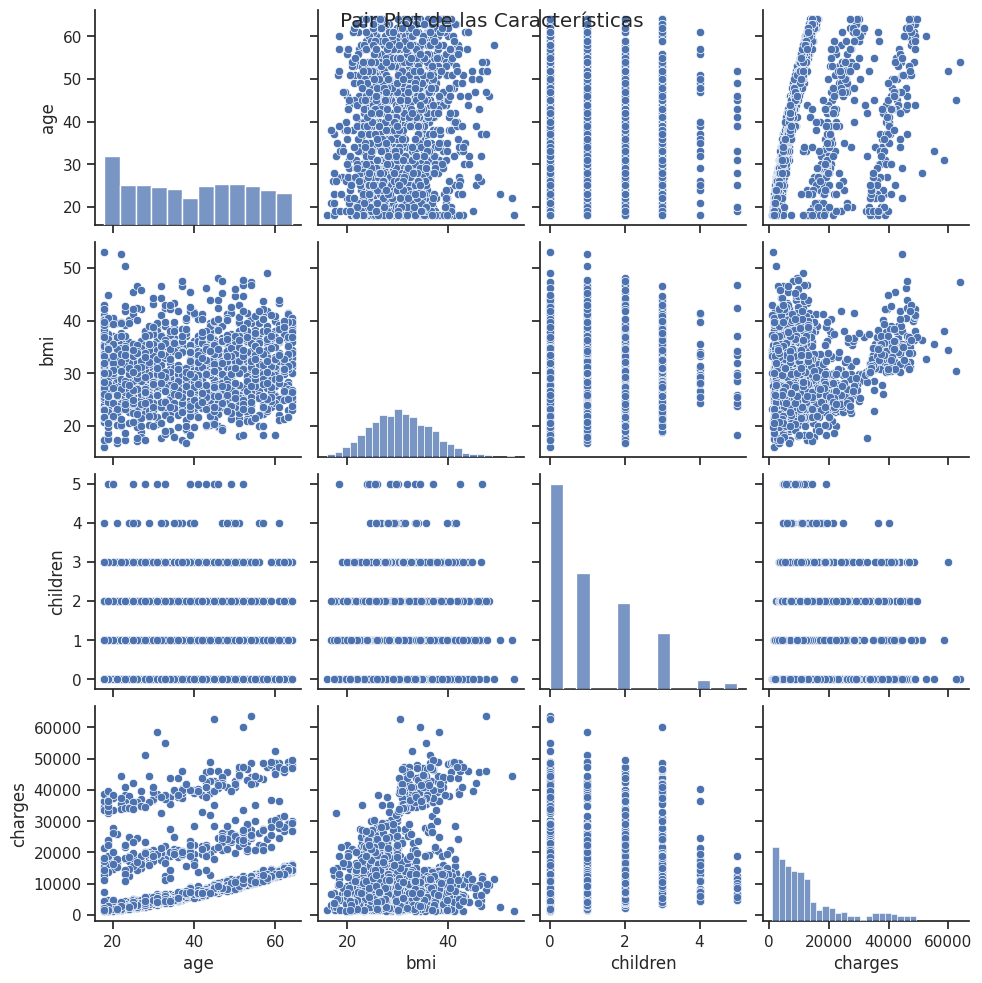

──────────────────────────────────────────── Descripción del Pair Plot ────────────────────────────────────────────

El pair plot muestra una representación gráfica de las relaciones entre las características del conjunto de datos.

En la diagonal, se presentan las distribuciones individuales de las características.

En las celdas fuera de la diagonal, se muestran los scatter plots entre cada par de características, lo que ayuda a
identificar patrones de correlación y tendencias.

In [10]:
# Creamos un pair plot para visualizar las morfología de las correlaciones
sns.set(style="ticks")
pair_plot = sns.pairplot(df)
plt.suptitle("Pair Plot de las Características")
plt.show()

# Imprimir una breve descripción del pair plot
console.rule("Descripción del Pair Plot")
console.print("El pair plot muestra una representación gráfica de las relaciones entre las características del conjunto de datos.")
console.print("En la diagonal, se presentan las distribuciones individuales de las características.")
console.print("En las celdas fuera de la diagonal, se muestran los scatter plots entre cada par de características, lo que ayuda a identificar patrones de correlación y tendencias.")


## Codificación de variables categóricas
El siguiente paso consiste en codificar las variables categóricas

In [16]:
import pandas as pd

# Variables categóricas a codificar
vars_to_encode = ['sex', 'smoker', 'region']

# Utilizamos el método get_dummies para codificar las variables categóricas
dummies = [pd.get_dummies(df[var], prefix=var) for var in vars_to_encode]
df_dummies = pd.concat(dummies, axis=1)

# Eliminamos las columnas originales de las variables categóricas
df = df.drop(vars_to_encode, axis=1)

# Ahora contatenamos las columnas codificadas con el DataFrame original
df_encoded = pd.concat([df, df_dummies], axis=1)

# Por último, renombramos las columnas para mayor claridad
df_encoded.rename(columns={'smoker_no': 'non-smoker', 'smoker_yes': 'nicotine-user'}, inplace=True)

# Mostrar el nuevo dataset correctamente configurado
console.log(f"Dataframe codificado: {df_encoded.head()}", style="bold yellow")


[16:02:43] Dataframe codificado:    age     bmi  children      charges           <ipython-input-16-c020189a0feb>:20
           sex_female  sex_male  non-smoker  \                                                                     
           0   19  27.900         0  16884.92400           1         0                                             
           0                                                                                                       
           1   18  33.770         1   1725.55230           0         1                                             
           1                                                                                                       
           2   28  33.000         3   4449.46200           0         1                                             
           1                                                                                                       
           3   33  22.705         0  21984.47061           0         1                                             
           1                                                                                                       
           4   32  28.880         0   3866.85520           0         1                                             
           1                                                                                                       
                                                                                                                   
              nicotine-user  region_northeast  region_northwest                                                    
           region_southeast  \                                                                                     
           0              1                 0                 0                                                    
           0                                                                                                       
           1              0                 0                 0                                                    
           1                                                                                                       
           2              0                 0                 0                                                    
           1                                                                                                       
           3              0                 0                 1                                                    
           0                                                                                                       
           4              0                 0                 1                                                    
           0                                                                                                       
                                                                                                                   
              region_southwest                                                                                     
           0                 1                                                                                     
           1                 0                                                                                     
           2                 0                                                                                     
           3                 0                                                                                     
           4                 0                                                                                     

## Normalización de los datos
La siguiente fase del pre-procesado consiste en re-escalar los datos. En este caso aplicaremos métodos de la clase StandardScaler de Sci-kit learn


 Dataset escalado: 
            age       bmi  children   charges  sex_female  sex_male  \
0    -1.438764 -0.453320 -0.908614  0.298584    1.010519 -1.010519   
1    -1.509965  0.509621 -0.078767 -0.953689   -0.989591  0.989591   
2    -0.797954  0.383307  1.580926 -0.728675   -0.989591  0.989591   
3    -0.441948 -1.305531 -0.908614  0.719843   -0.989591  0.989591   
4    -0.513149 -0.292556 -0.908614 -0.776802   -0.989591  0.989591   
...        ...       ...       ...       ...         ...       ...   
1333  0.768473  0.050297  1.580926 -0.220551   -0.989591  0.989591   
1334 -1.509965  0.206139 -0.908614 -0.914002    1.010519 -1.010519   
1335 -1.509965  1.014878 -0.908614 -0.961596    1.010519 -1.010519   
1336 -1.296362 -0.797813 -0.908614 -0.930362    1.010519 -1.010519   
1337  1.551686 -0.261388 -0.908614  1.311053    1.010519 -1.010519   

      non-smoker  nicotine-user  region_northeast  region_northwest  \
0      -1.970587       1.970587         -0.565267         -0.56641

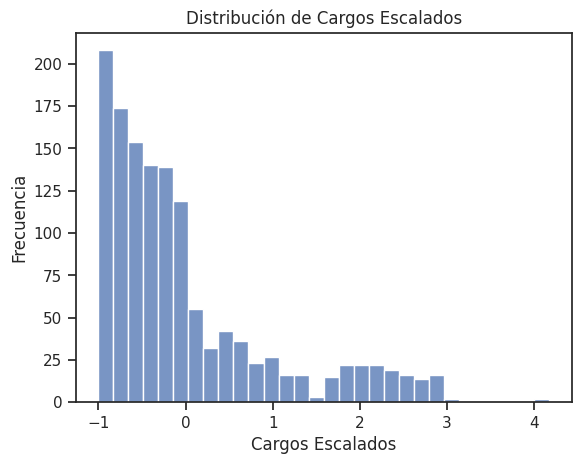

In [18]:
from sklearn.preprocessing import StandardScaler

# Crear una copia del DataFrame codificado para el escalado
df_c_scaled = df_encoded.copy()

# Utilizar StandardScaler para escalar el conjunto de datos
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_c_scaled)
df_c_scaled[df_c_scaled.columns] = scaled_features

# Mostrar el conjunto de datos escalado
print("\n Dataset escalado: \n", df_c_scaled)

# Visualizar la distribución de la columna "charges" en el conjunto de datos escalado
sns.histplot(df_c_scaled["charges"])
plt.title("Distribución de Cargos Escalados")
plt.xlabel("Cargos Escalados")
plt.ylabel("Frecuencia")
plt.show()

## Extracción de características

Text(0, 0.5, 'Porcentaje de varianza explicado')

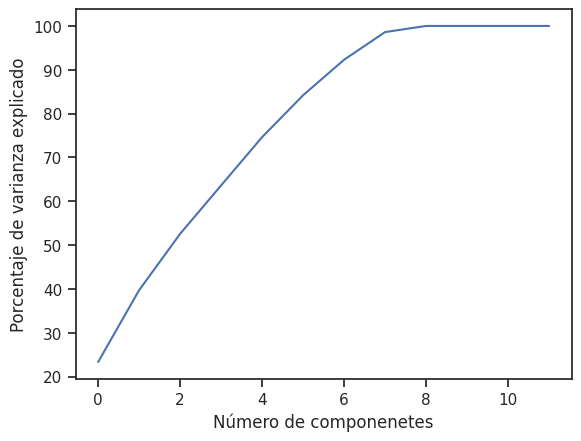

In [19]:
# Aplicaremos la técnica PCA para identificar las variables más representativas
from sklearn.decomposition import PCA
df_s = df_c_scaled # Nuestro DataFrame de trabajo previamente procesado

# Los nombres de las características se identifican en las cabeceras de las columnas
features = df_s.columns
X = df_s[features]

# Analizamos el conjunto completo de variables
pca = PCA(n_components=len(features), random_state=2020)
pca.fit(X)
X_pca = pca.transform(X)

# Representamos en un gráfico el procentaje de varianza frente al número de componentes
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Número de componenetes")
plt.ylabel("Porcentaje de varianza explicado")

In [23]:
# Creamos una instancia de PCA con 6 componentes principales
pca_s = PCA(n_components=6, random_state=2020)

# Ajustamos el modelo PCA a los datos originales
pca_s.fit(X)

# Transformamos los datos originales utilizando las componentes principales
X_pca_s = pca_s.transform(X)

# Creamos un nuevo DataFrame con los datos transformados
cols = ['PCA' + str(i) for i in range(1, 7)]  # Cambiado para que las componentes sean del 1 al 6
df_pca = pd.DataFrame(X_pca_s, columns=cols)

# Finalmente observamos el conjunto de datos transformado con las 6 componentes principales
console.log(f"Datos para las 6 componentes principales:{df_pca}", style="bold yellow")

[16:08:39] Datos para las 6 componentes principales:          PCA1      PCA2     <ipython-input-23-51cd914b2008>:15
           PCA3      PCA4      PCA5      PCA6                                                                      
           0     1.794247  1.834668 -0.797065  1.761831 -0.520355 -2.435473                                        
           1    -0.622380 -1.748394  1.626639 -0.870391  0.064339 -1.527498                                        
           2    -0.414757 -1.690923  1.615243 -0.585496  0.216697 -0.392165                                        
           3    -0.195383 -1.336715 -1.440494 -0.418641  1.708185 -0.347876                                        
           4    -0.904619 -1.576005 -0.928444 -0.467650  1.681639 -0.477592                                        
           ...        ...       ...       ...       ...       ...       ...                                        
           1333 -0.410680 -1.469268 -0.644184  0.008130  1.909517  1.570023                                        
           1334 -1.505168  1.096178 -0.701978 -1.298499 -1.526170 -1.011097                                        
           1335 -1.213596  0.991307  2.075771 -0.955261 -0.022759 -1.765757                                        
           1336 -1.682817  1.076329 -0.381511  1.619760 -0.594675 -1.842200                                        
           1337  2.555342  2.187712 -1.094759 -0.066644  1.767942  0.687237                                        
                                                                                                                   
           [1338 rows x 6 columns]                                                                                 

## Ajuste del modelo lineal
Completado el proceso de preparación de datos realizaremos el ajuste del modelo

In [26]:
from sklearn.model_selection import train_test_split

# Las características que vamos a analizar son las seleccionadas con PCA
pca_features = df_pca.columns
X = df_pca[pca_features]
y = df_s['charges']

# Usamos la función train_test_split de sklearn para dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

print("Tamaño de los conjuntos de entrenamiento y prueba:")
print(" - X_train:", X_train.shape)
print(" - X_test:", X_test.shape)
print(" - y_train:", y_train.shape)
print(" - y_test:", y_test.shape)


Tamaño de los conjuntos de entrenamiento y prueba:
 - X_train: (802, 6)
 - X_test: (536, 6)
 - y_train: (802,)
 - y_test: (536,)


In [27]:
# Exponemos el conjunto de entrenamiento al modelo de regresión lineal

from sklearn.linear_model import LinearRegression

# Creamos una instancia del modelo de regresión lineal
lm = LinearRegression()

# Ajustamos el modelo a los datos de entrenamiento
lm.fit(X_train, y_train)


LinearRegression()

In [29]:
from sklearn import metrics
import numpy as np

# Calculamos las predicciones del modelo sobre el conjunto de prueba
y_pred = lm.predict(X_test)

# Calculamos descriptores de ajuste y rendimiento del modelo
evar = metrics.explained_variance_score(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# finalemente, imprimimos por pantall los descriptores de ajuste y rendimiento
print("Descriptores de ajuste y rendimiento:")
print('- Varianza explicada: ', round(evar, 2))
print('- R2:', round(r2, 2))
print('- MAE: ', round(mae, 4))
print('- MSE: ', round(mse, 4))
print('- RMSE: ', round(rmse, 4))


Descriptores de ajuste y rendimiento:
- Varianza explicada:  0.89
- R2: 0.89
- MAE:  0.2282
- MSE:  0.1075
- RMSE:  0.3278


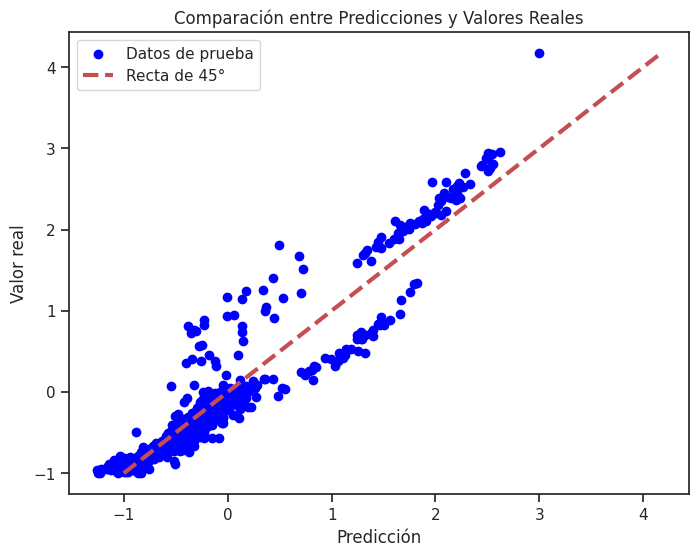

In [30]:
# Para terminar, representamos las predicciones del modelo en una gráfica:

# Scatter plot de predicciones vs. valores reales
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_pred, y_test, color='blue', edgecolors=(0, 0, 1), label='Datos de prueba')
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Recta de 45°')

# Etiquetas y título del gráfico
ax.set_xlabel('Predicción')
ax.set_ylabel('Valor real')
ax.set_title('Comparación entre Predicciones y Valores Reales')
ax.legend()
plt.show()
